In [111]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import rel_entr
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [112]:
env_name = 'stag_hunt_O'
load_dir = './data_index/'+env_name+'_5M.npz'
export_dir = './plots_index/'

loaded = np.load(load_dir)
rewards = loaded['rewards']
checkpoints = loaded['checkpoints']
row_rewards = rewards[:,:,0]
col_rewards = rewards[:,:,1]
row_rewards

array([[14.59611993, 14.74340474, 11.62565487, 22.5081167 , 13.37147826,
        16.98773197, 17.26497629, 20.58512767, 11.4931896 , 14.15410683,
        19.08379525, 22.01495726, 11.82846973, 20.30870611, 14.46420246,
        13.41075134, 12.44952381, 21.75177415, 12.1571029 , 17.07810458,
        16.69461015,  5.35833333, 17.73196581, 13.25775965, 19.69546398,
        10.13142857, 17.26280794,  8.80639731, 19.00966811, 16.13943191,
        15.4397892 , 11.32263451, 16.69205631, 19.41764706, 20.76793651,
        14.35214211, 12.93458689, 11.70595418, 20.3049062 , 12.27150072,
        20.22326683,  9.89141414, 20.63421245, 15.44154642, 15.37347487,
        15.72329004, 13.44761905, 15.56908924, 17.46736111, 21.25622352],
       [29.78668316, 24.33717172, 17.19370907, 14.81468466, 20.9517316 ,
        21.77323232, 18.99785069, 29.24128427, 22.14920217, 26.6051443 ,
        23.49069264, 22.68339438, 13.42718316, 24.03842965, 18.3772385 ,
        15.62771677, 21.11265824, 22.52781488, 25.

### KL Divergence

In [113]:
# start = np.min(row_rewards)
# end = np.max(row_rewards)
start = 0
end = 150
num_bins = 50
# marginal distribution
total_rewards = row_rewards.flatten()
marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
marginal_distribution = marginal_hist / sum(marginal_hist)
# KL divergence
KL_divergence = np.zeros(len(row_rewards))
for i in range(len(row_rewards)):
    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
    distribution = hist / sum(hist)
    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
# index
index = sum(KL_divergence)/len(KL_divergence)
print(index)

0.577990726432601


### Turn to DataFrame

In [114]:
# convert to dataframe for plotting
checkpoint_str = ["checkpoint "+str(x) for x in checkpoints]
# reshape the 2D Numpy array to 1D array
flattened_ego_rewards = row_rewards.flatten()
flattened_opp_rewards = col_rewards.flatten()
# Create column names for the DataFrame
column_names = ['row reward', 'col reward', 'checkpoint']
# Create an array with repeated row numbers
checkpoint_names = np.repeat(checkpoint_str, len(row_rewards[0]))
# Create the DataFrame
df = pd.DataFrame({'row reward': flattened_ego_rewards, 'col reward': flattened_opp_rewards, 'checkpoint': checkpoint_names}, columns=column_names)
df

,row reward,col reward,checkpoint
0,14.596120,16.005562,checkpoint 20
1,14.743405,14.677481,checkpoint 20
2,11.625655,11.183404,checkpoint 20
3,22.508117,23.164584,checkpoint 20
4,13.371478,14.221913,checkpoint 20
...,...,...,...
545,30.692174,30.986874,checkpoint 2460
546,33.595211,31.813576,checkpoint 2460
547,36.758060,34.158493,checkpoint 2460
548,29.347419,29.548188,checkpoint 2460


### Ridge Plot

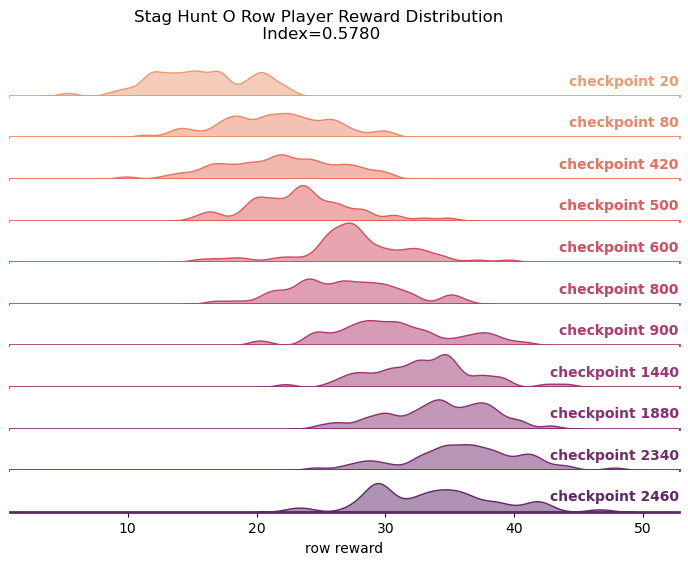

In [115]:
g = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='flare')
# h = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='crest')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="row reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map_dataframe(sns.kdeplot, x="opp_reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "row reward")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=env_name.replace('_',' ').title() + f' Row Player Reward Distribution\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join(export_dir, env_name.replace('_',' ')+' row reward distribution.pdf'), bbox_inches='tight')

### Comparison DataFrame

In [116]:
new_df = pd.DataFrame({'reward': df['col reward'].tolist()+df['row reward'].tolist(),
                       'label': ['col']*len(df['col reward'])+['row']*len(df['row reward']),
                       'checkpoint': df['checkpoint'].tolist()*2},
                      columns=['reward','label','checkpoint'])
new_df

,reward,label,checkpoint
0,16.005562,col,checkpoint 20
1,14.677481,col,checkpoint 20
2,11.183404,col,checkpoint 20
3,23.164584,col,checkpoint 20
4,14.221913,col,checkpoint 20
...,...,...,...
1095,30.692174,row,checkpoint 2460
1096,33.595211,row,checkpoint 2460
1097,36.758060,row,checkpoint 2460
1098,29.347419,row,checkpoint 2460


### Comparison Ridge Plot

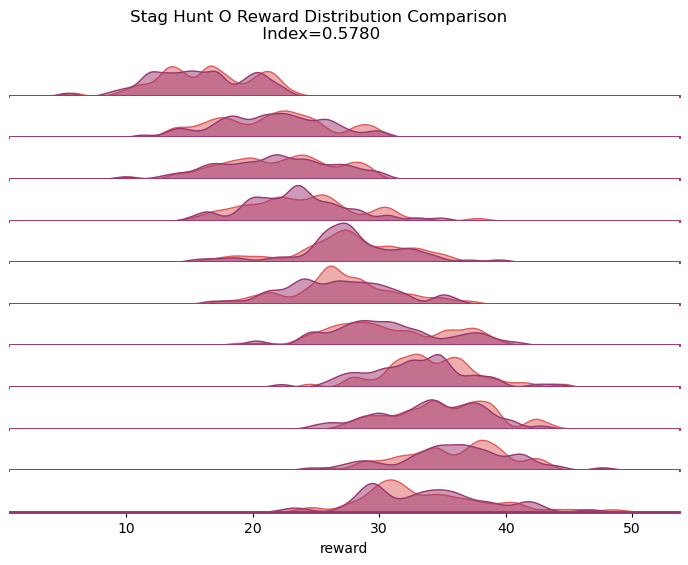

In [117]:
g = sns.FacetGrid(new_df, row="checkpoint", hue="label", aspect=15, height=.5, palette='flare')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.3)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # ax.text(1, .2, label, fontweight="bold", color=color,
    #         ha="right", va="bottom", transform=ax.transAxes)
# def annotate(data, color, **kws):
#     n = data['checkpoint']
#     ax = plt.gca()
#     ax.text(1, 0.2, f'{n}', fontweight="bold", color=color, ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "reward")
# g.map_dataframe(annotate)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=env_name.replace('_',' ').title() + f' Reward Distribution Comparison\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join(export_dir, env_name.replace('_',' ')+' distribution comparison.pdf'), bbox_inches='tight')